### Imports

In [1]:
import torch
import numpy as np
import pandas as pd
from monai.apps.datasets import DecathlonDataset
from monai.losses import DiceCELoss
from monai.config import print_config
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd, ScaleIntensityRanged, EnsureTyped
from monai.utils import set_determinism
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from typing import Literal

In [ ]:
RNG_SEED = 101
torch.manual_seed(RNG_SEED)
np.random.seed(RNG_SEED)
set_determinism(seed=RNG_SEED) 

In [3]:
print_config()

MONAI version: 1.5.1
Numpy version: 2.2.6
Pytorch version: 2.8.0+cu126
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 9c6d819f97e37f36c72f3bdfad676b455bd2fa0d
MONAI __file__: /opt/conda/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.15.3
Pillow version: 11.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.23.0+cu126
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0
pandas version: 2.3.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 3.5.1
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VE

In [4]:
root_dir = Path("./brain_tumor_data")
root_dir.mkdir(parents=True, exist_ok=True)

transforms = Compose([
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0),
                 mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=4000, b_min=0.0, b_max=1.0, clip=True
        ),
        EnsureTyped(keys=["image", "label"]),
])

train_dataset = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=2,
    seed=RNG_SEED,
    transform=transforms
)

val_dataset = DecathlonDataset(
    root_dir=str(root_dir),
    task="Task01_BrainTumour",
    section="validation",
    download=True,
    cache_num=0,
    num_workers=2,
    seed=RNG_SEED
)
test_dataset = DecathlonDataset(
    root_dir=str(root_dir),
    task="Task01_BrainTumour",
    section="test",
    download=True,
    cache_num=0,
    num_workers=2,
)

/opt/conda/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


2025-11-08 06:26:02,012 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2025-11-08 06:26:02,012 - INFO - File exists: brain_tumor_data/Task01_BrainTumour.tar, skipped downloading.
2025-11-08 06:26:02,015 - INFO - Non-empty folder exists in brain_tumor_data/Task01_BrainTumour, skipped extracting.
2025-11-08 06:26:35,552 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2025-11-08 06:26:35,552 - INFO - File exists: brain_tumor_data/Task01_BrainTumour.tar, skipped downloading.
2025-11-08 06:26:35,556 - INFO - Non-empty folder exists in brain_tumor_data/Task01_BrainTumour, skipped extracting.
2025-11-08 06:27:09,061 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2025-11-08 06:27:09,062 - INFO - File exists: brain_tumor_data/Task01_BrainTumour.tar, skipped downloading.
2025-11-08 06:27:09,065 - INFO - Non-empty folder exists in brain_tumor_data/Task01_BrainTumour, skipped extracting.


In [5]:
print(f"Training Set Size: {len(train_dataset)}")
print(f"Validation Set Size: {len(val_dataset)}")
print(f"test Set Size: {len(test_dataset)}")

Training Set Size: 388
Validation Set Size: 96
test Set Size: 266


In [6]:
sample = train_dataset[1]
image, label = sample["image"], sample["label"]

In [244]:
train_dataset.data[9]

{'image': 'brain_tumor_data/Task01_BrainTumour/imagesTr/BRATS_093.nii.gz',
 'label': 'brain_tumor_data/Task01_BrainTumour/labelsTr/BRATS_093.nii.gz'}

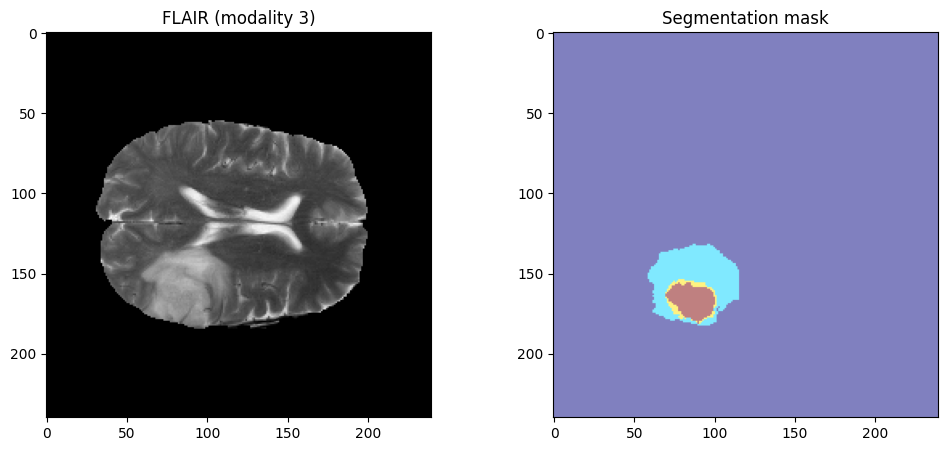

In [7]:
# pick slice index
slice_idx = image.shape[-1] // 2  

# modality 3 = FLAIR
modality_idx = 3  

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("FLAIR (modality 3)")
plt.imshow(image[modality_idx, :, :, slice_idx], cmap="gray")

plt.subplot(1,2,2)
plt.title("Segmentation mask")
plt.imshow(label[0, :, :, slice_idx], cmap="jet", alpha=0.5)
plt.show()


"labels": { 
    "0": "background", 
    "1": "edema",
    "2": "non-enhancing tumor",
    "3": "enhancing tumour"
}

Teacher: UNETR (BraTS)

Student: BasicUNet

| Dimension | Meaning                     | Example                                                                  |
| --------- | --------------------------- | ------------------------------------------------------------------------ |
| **B**     | Batch size                  | e.g., number of MRI volumes in a batch                                   |
| **C**     | Channel (class or modality) | e.g., number of segmentation classes, or image modalities (T1, T2, etc.) |
| **H**     | Height                      | Number of pixels per slice vertically                                    |
| **W**     | Width                       | Number of pixels per slice horizontally                                  |
| **D**     | Depth                       | Number of slices in the 3D volume (z-axis)                               |


<Axes: >

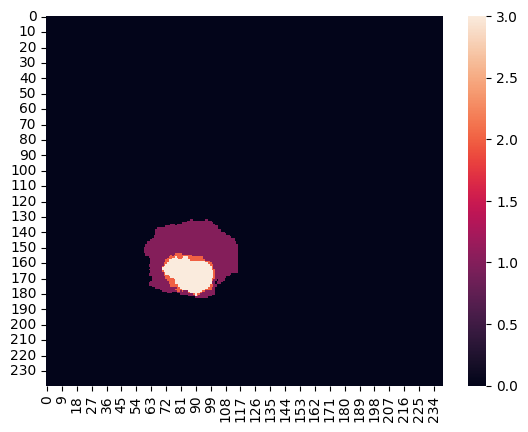

In [8]:
sns.heatmap(
    data=label[0, :, :, slice_idx]
)

In [10]:
label.shape

torch.Size([1, 240, 240, 155])

In [ ]:
# class KDSoftLoss(nn.Module):
#     def __init__(self, logits_dim: int = 1, alpha:float=0.5, temperature: float = 0.5, eps: float = 1e-8):
#         super().__init__()
#         self.temperature = temperature
#         self.alpha = alpha
#         self.logits_dim = logits_dim
#         # to avoid log(0) numerical safety
#         self.eps = eps

#     def forward(self, student_logits: torch.Tensor, teacher_logits: torch.Tensor):
#         teacher_probabilities = F.softmax(teacher_logits / self.temperature , dim=self.logits_dim).clamp(min=self.eps)
#         print(teacher_probabilities.shape)
#         student_probabilities = F.softmax(student_logits / self.temperature, dim=self.logits_dim).clamp(min=self.eps)
#         kl_div = (teacher_probabilities * (teacher_probabilities.log() - student_probabilities.log())).sum()
#         print(kl_div.shape)
#         return self.alpha * (self.temperature ** 2) * kl_div

class KDSoftLoss(nn.Module):
    def __init__(self, logits_dim: int = 1, temperature: float = 0.5, log_target: bool = False, reduction: Literal["sum", "batchmean", "mean"] = "batchmean"):
        super().__init__()
        self.temperature = temperature
        # self.alpha = alpha
        self.logits_dim = logits_dim
        self.log_target = log_target
        self.reduction = reduction

    def forward(self, student_logits: torch.Tensor, teacher_logits: torch.Tensor):
        teacher_probabilities = F.log_softmax(teacher_logits / self.temperature , dim=self.logits_dim) if self.log_target else F.softmax(teacher_logits / self.temperature , dim=self.logits_dim) 
        student_probabilities = F.log_softmax(student_logits / self.temperature, dim=self.logits_dim)
        kl_div = F.kl_div(student_probabilities, teacher_probabilities, reduction=self.reduction, log_target=self.log_target)
        # return self.alpha * (self.temperature ** 2) * kl_div
        return (self.temperature ** 2) * kl_div

class KDHardSoftLoss(nn.Module):
    def __init__(self, hard_loss: nn.Module, soft_loss: nn.Module, alpha:float=0.5):
        super().__init__()
        assert 0.0 <= alpha <= 1.0
        self.hard_loss = hard_loss
        self.soft_loss = soft_loss
        # adjust weight trade-off between hard loss and soft loss
        self.alpha = alpha
    
    def forward(self, student_logits: torch.Tensor, targets: torch.Tensor, teacher_logits: torch.Tensor):
        # avoids backprop into the teacher by accident.
        teacher_logits = teacher_logits.detach()
        # hard = self.hard_loss(student_logits, targets)
        return (1.0 - self.alpha) * self.hard_loss(student_logits, targets) +  self.alpha * self.soft_loss(student_logits, teacher_logits)

In [200]:
kd_loss = KDSoftLoss(logits_dim=1)
# batch_label = label.unsqueeze(dim=0)
# batch_label.shape
# batch_test = torch.concat((label.unsqueeze(dim=0), label.unsqueeze(dim=0), label.unsqueeze(dim=0)))
pre_y = torch.rand((4, 240, 240, 155))

In [215]:
# batch_y_test = torch.concat((label.unsqueeze(dim=0), label.unsqueeze(dim=0), label.unsqueeze(dim=0)))
# batch_pred_y_test = torch.concat((pre_y.unsqueeze(dim=0), pre_y.unsqueeze(dim=0), pre_y.unsqueeze(dim=0)))
batch_y_test = label.unsqueeze(dim=0).expand(-1,-1,-1,-1,-1).repeat(3,1,1,1,1)
batch_pred_y_test = torch.concat((pre_y.unsqueeze(dim=0), pre_y.unsqueeze(dim=0), pre_y.unsqueeze(dim=0)))
batch_teacher_y_test = torch.concat((pre_y.unsqueeze(dim=0) * 2, pre_y.unsqueeze(dim=0) * 2, pre_y.unsqueeze(dim=0) * 2))
# batch_y_test.shape
# batch_pred_y_test.shape
test_loss_res = kd_loss(batch_pred_y_test, batch_teacher_y_test)

torch.Size([3, 4, 240, 240, 155])
torch.Size([])


In [216]:
print(f"{batch_y_test.shape}")
print(f"{batch_pred_y_test.shape}")
print(f"{batch_teacher_y_test.shape}")

torch.Size([3, 1, 240, 240, 155])
torch.Size([3, 4, 240, 240, 155])
torch.Size([3, 4, 240, 240, 155])


In [217]:
loss_alpha = 0.5
combined_loss_f = KDHardSoftLoss(
    hard_loss=DiceCELoss(
        to_onehot_y=True,
        softmax=True,
        # lambda_ce=(1-loss_alpha)
    ),
    soft_loss=KDSoftLoss(logits_dim=1),
    # soft_loss=kd_loss,
    alpha=loss_alpha
)

test_combined_loss_res = combined_loss_f(
    student_logits=batch_pred_y_test,
    targets=batch_y_test,
    teacher_logits=batch_teacher_y_test
)
test_combined_loss_res.shape

metatensor(2.3126)
torch.Size([3, 4, 240, 240, 155])
torch.Size([])


torch.Size([])

In [218]:
# batch_y_test.shape
print(test_loss_res)
print(test_combined_loss_res)

tensor(160078.3750)
metatensor(80040.3438)


TODO: save teacher logits for each training and validation sample, then uses the saved teacher logits to train student without teacher